# Customer & Sales Analytics
## RFM Analysis (Recency, Frequency , Monetary)

### Objective
The onjective of this notebook is to perform **RFM analysis** to segment customers based on their purchasing behavior. RFM analysis evaluates customers using three key dimentions:

- **Recency** - How recently a customer made a purchase
- **Frequency** - How often a customer makes a purchase
- **Monetary** - How much a customer spends

### Why RFM?
RFM analysis hepls indentify:
- High-value and loyal customers
- Recently acquired customers
- Customers at risk of churn
- Low-engagement or lost customers

This notebook uses the **processed master dataset** generated in previous steps and focuses exclusively on **customer-level aggregation and segmentation**.


In [2]:
# RFM analysis

# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings 
warnings.filterwarnings ("ignore")

# set visualiation style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [3]:
# load dataset
master_df = pd.read_csv(
    r"OneDrive/Documents/Customer Sales Analytics/master_table_processed.csv",
    parse_dates=["order_purchase_timestamp"]
)

print(f"Data loaded: {master_df.shape[0]:,} orders")

Data loaded: 96,478 orders


In [5]:
master_df.head(4)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,order_month,order_day_of_week,is_weeknd,year_month,avg_item_price,freight_percentage,satisfaction_score,is_weekend,is_extreme_delay,delivery_time_days_capped
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,10,0,0,2017-10,29.99,22.526479,4.0,0,0,8.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,7,1,0,2018-07,118.70,16.089354,4.0,0,0,13.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,8,2,0,2018-08,159.90,10.730237,5.0,0,0,9.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,11,5,1,2017-11,45.00,37.673130,5.0,1,0,13.0


# Calculate RFM Metrics

In [7]:
# refrenece date (snapshot_date)
# snapshot date - the day after the most recent order in the dataset
# best for recency calculation

snapshot_date = master_df["order_purchase_timestamp"].max() + timedelta(days=1)

print(f"Snapshot date: {snapshot_date.date()}")

Snapshot date: 2018-08-30


In [10]:
# calculate RFM per customer

rfm = (
    master_df
    .groupby("customer_unique_id")
    .agg(
        recency=("order_purchase_timestamp",
                lambda x: (snapshot_date - x.max()).days),
        frequency=("order_id", "count"),
        monetary=("order_revenue", "sum")
    )
    .reset_index()
)

print(f"RFM calculated for {rfm.shape[0]:,} customers")

RFM calculated for 93,358 customers


In [11]:
# display RFM statistics 
print("\n===== RFM STATISTICS =====")
print(rfm[['recency', 'frequency', 'monetary']].describe())


===== RFM STATISTICS =====
            recency     frequency      monetary
count  93358.000000  93358.000000  93358.000000
mean     237.941773      1.033420    165.168210
std      152.591453      0.209097    226.292101
min        1.000000      1.000000      9.590000
25%      114.000000      1.000000     63.010000
50%      219.000000      1.000000    107.780000
75%      346.000000      1.000000    182.510000
max      714.000000     15.000000  13664.080000


# RFM Distribution Analysis


===== RFM DISTRIBUTION ANALYSIS =====


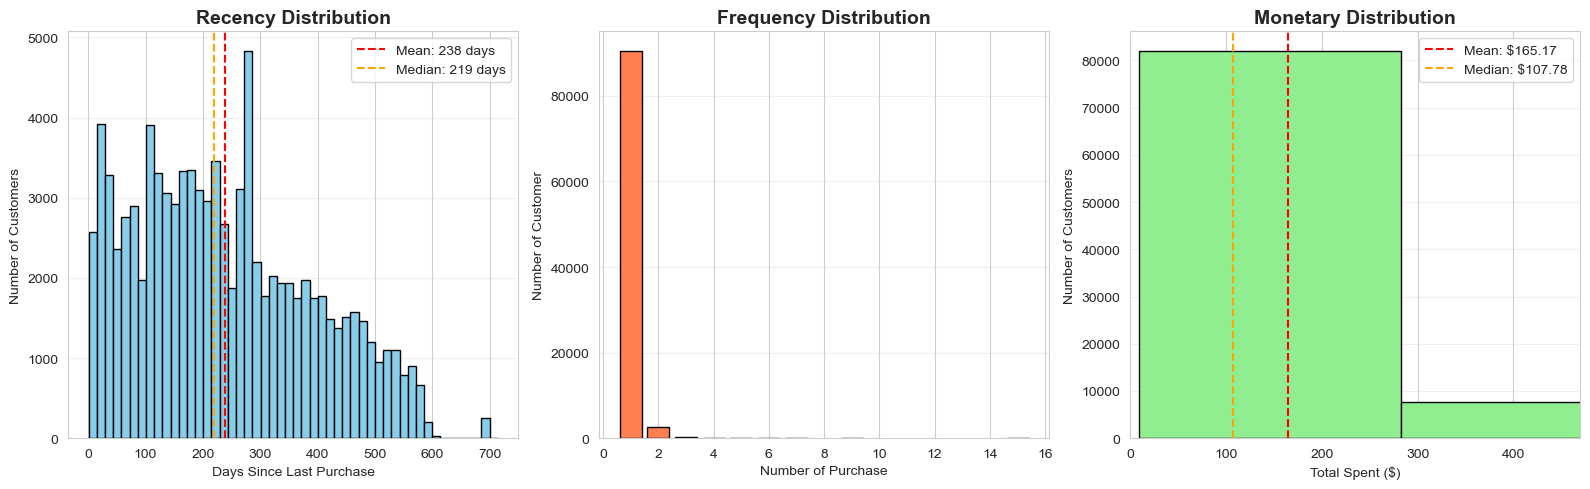

In [15]:
print("\n===== RFM DISTRIBUTION ANALYSIS =====")

fig, ax = plt.subplots(1, 3, figsize=(16, 5))

# recency distribution
ax[0].hist(rfm['recency'], bins=50, color='skyblue', edgecolor='black')
ax[0].axvline(rfm['recency'].mean(), color='red', linestyle='--',
             label=f"Mean: {rfm['recency'].mean():.0f} days")
ax[0].axvline(rfm['recency'].median(), color='orange', linestyle='--',
             label=f"Median: {rfm['recency'].median():.0f} days")
ax[0].set_title('Recency Distribution', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Days Since Last Purchase')
ax[0].set_ylabel('Number of Customers')
ax[0].legend()
ax[0].grid(axis='y', alpha=0.3)

# freuency distribution
freq_counts = rfm['frequency'].value_counts().sort_index().head(10)
ax[1].bar(freq_counts.index, freq_counts.values, color='coral', edgecolor='black')
ax[1].set_title('Frequency Distribution', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Number of Purchase')
ax[1].set_ylabel('Number of Customer')
ax[1].grid(axis='y', alpha=0.3)

# monetary distribution
ax[2].hist(rfm['monetary'], bins=50, color='lightgreen', edgecolor='black')
ax[2].axvline(rfm['monetary'].mean(), color='red', linestyle='--',
             label=f"Mean: ${rfm['monetary'].mean():.2f}")
ax[2].axvline(rfm['monetary'].median(), color='orange', linestyle='--',
             label=f"Median: ${rfm['monetary'].median():.2f}")
ax[2].set_title('Monetary Distribution', fontsize=14, fontweight='bold')
ax[2].set_xlabel('Total Spent ($)')
ax[2].set_ylabel('Number of Customers')
ax[2].set_xlim(0, rfm['monetary'].quantile(0.95)) # focus on 95%
ax[2].legend()
ax[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# freuency statistics
print(f"\n===== FREQUENCY STATISTICS =====")

print(f"One-time customers: {(rfm['frequency'] == 1).mean()*100:.1f}%")
print(f"Repeat customers: {(rfm['frequency'] > 1).mean()*100:.1f}%")


===== FREQUENCY STATISTICS =====
One-time customers: 97.0%
Repeat customers: 3.0%


# RFM Scoring

In [17]:
# RFM scores using quantiles
# Recency: Lower is better (recent customers) - reverse scoring
# Frequency: Higher is better - normal scoring
# Monetary: Higher is better - normal scoring

print(f"\n===== RFM SCORING =====")

# recency scoring (1=oldest, 5=recent)
rfm['R_score'] = pd.qcut(  # qcut splits buyers
    rfm['recency'],
    q=5,
    labels=[5,4,3,2,1],
    duplicates='drop'
).astype(int)

# frequency scoring
# given 97% have frequency=1, use custom binning

def frequency_score(freq):
    if freq == 1:
        return 1 # one-time buyers
    elif freq == 2:
        return 3  # bought twice
    else:
        return 5 # loyal customers (3+ purchases)

rfm['F_score'] = rfm['frequency'].apply(frequency_score)

# monetary scoring (1 = lowest spenders, 5 = highest spenders)

rfm['M_score'] = pd.qcut(
    rfm['monetary'],
    q=5,
    labels=[1,2,3,4,5],
    duplicates='drop'
).astype(int)

# create RFM segment string (e.g., "555" for best customers)
rfm['RFM_segment'] = (
    rfm['R_score'].astype(str) + 
    rfm['F_score'].astype(str) + 
    rfm['M_score'].astype(str)
)

# calculate overall RFM score (average)
rfm['RFM_score'] = (rfm['R_score'] + rfm['F_score'] + rfm['M_score']) / 3

print("RFM scores created successfully")
print(f"\nScore distributions:")
print(f"R_score: {rfm['R_score'].value_counts().sort_index().to_dict()}")
print(f"F_score: {rfm['F_score'].value_counts().sort_index().to_dict()}")
print(f"M_score: {rfm['M_score'].value_counts().sort_index().to_dict()}")


===== RFM SCORING =====
RFM scores created successfully

Score distributions:
R_score: {1: 18639, 2: 18577, 3: 18709, 4: 18705, 5: 18728}
F_score: {1: 90557, 3: 2573, 5: 228}
M_score: {1: 18676, 2: 18669, 3: 18670, 4: 18671, 5: 18672}


# Customer Segmentation

In [19]:
# customer segmentation

print(f"\n===== CUSTOMER SEGMENTATION =====")

# define segments based on RFM scores
def rfm_segment_label(row):
    r, f, m = row['R_score'], row['F_score'], row['M_score']
    
    # Champions: Best customers (recent, frequent, high spend)
    if r >= 4 and f >= 3 and m >= 4:
        return 'Champions'
    
    # Loyal: Frequent buyers regardless of recency
    elif f >= 3 and m >= 3:
        return 'Loyal Customers'
    
    # Big Spenders: High monetary, low frequency
    elif m >= 4 and f == 1:
        return 'Big Spenders'
    
    # Recent Customers: Bought recently but only once
    elif r >= 4 and f == 1:
        return 'Recent Customers'
    
    # At Risk: Haven't purchased recently, were frequent
    elif r <= 2 and f >= 3:
        return 'At Risk'
    
    # Lost: Old customers who bought only once
    elif r <= 2 and f == 1:
        return 'Lost Customers'
    
    # Potential: Medium recency, low frequency, medium spend
    else:
        return 'Potential'

rfm['customer_segment'] = rfm.apply(rfm_segment_label, axis=1)


===== CUSTOMER SEGMENTATION =====


In [25]:
# segment summary
segment_summary = (
    rfm
    .groupby('customer_segment')
    .agg(
        count=('customer_unique_id', 'count'),
        avg_recency=('recency', 'mean'),
        avg_frequency=('frequency', 'mean'),
        avg_monetary=('monetary', 'mean'),
        total_revenue=('monetary', 'sum')
    )
    .sort_values('total_revenue', ascending=False)
    .reset_index()
)

segment_summary['percentage'] = (segment_summary['count'] / len(rfm) * 100).round(1)

print("\n===== SEGMENT SUMMARY =====")
print(segment_summary)


===== SEGMENT SUMMARY =====
   customer_segment  count  avg_recency  avg_frequency  avg_monetary  \
0      Big Spenders  35104   235.382577       1.000000    299.903699   
1    Lost Customers  22493   396.068777       1.000000     72.701283   
2  Recent Customers  21770    89.970694       1.000000     72.908077   
3         Potential  11291   219.508015       1.008945     71.942089   
4   Loyal Customers   1628   296.804668       2.082310    296.770633   
5         Champions    990    88.827273       2.182828    372.043202   
6           At Risk     82   412.914634       2.048780     69.658659   

   total_revenue  percentage  
0    10527819.45        37.6  
1     1635269.96        24.1  
2     1587208.84        23.3  
3      812298.13        12.1  
4      483142.59         1.7  
5      368322.77         1.1  
6        5712.01         0.1  


# Segment Visualization

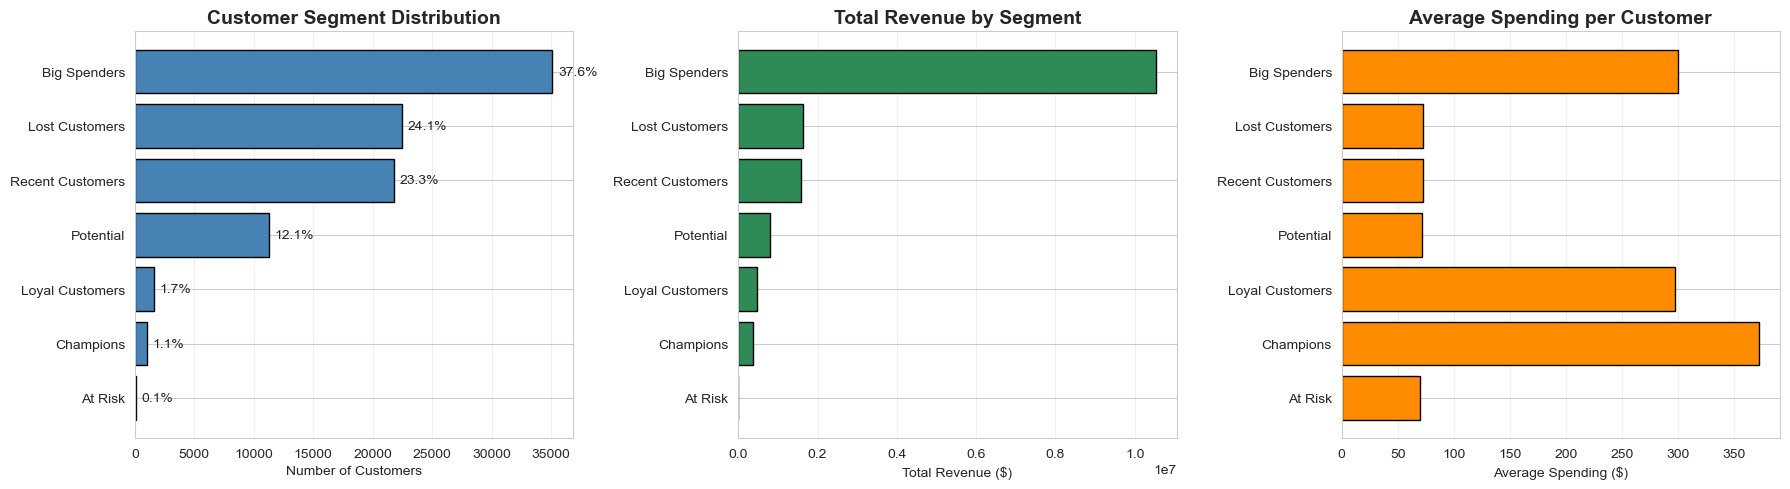

===== CUSTOMER SEGMENT SUMMARY =====
Total Customers: 93,358
Top Revenue Segment: Big Spenders


In [37]:
# ensure proper ordering
segment_summary_sorted = segment_summary.sort_values("count", ascending=True)
total_customers = segment_summary_sorted["count"].sum()
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# 1. customer segment distribution (BAR + %)
bars = ax[0].barh(
    segment_summary_sorted["customer_segment"],
    segment_summary_sorted["count"],
    color="steelblue",
    edgecolor="black"
)

ax[0].set_title("Customer Segment Distribution", fontsize=14, fontweight="bold")
ax[0].set_xlabel("Number of Customers")
ax[0].grid(axis="x", alpha=0.3)

# percentage labels
for bar in bars:
    count = bar.get_width()
    percentage = (count / total_customers) * 100
    ax[0].text(
        count + total_customers * 0.005,
        bar.get_y() + bar.get_height() / 2,
        f"{percentage:.1f}%",
        va="center",
        fontsize=10
    )

# 2. total revenue by segment
ax[1].barh(
    segment_summary_sorted["customer_segment"],
    segment_summary_sorted["total_revenue"],
    color="seagreen",
    edgecolor="black"
)

ax[1].set_title("Total Revenue by Segment", fontsize=14, fontweight="bold")
ax[1].set_xlabel("Total Revenue ($)")
ax[1].grid(axis="x", alpha=0.3)


# 3. average spending per customer
ax[2].barh(
    segment_summary_sorted["customer_segment"],
    segment_summary_sorted["avg_monetary"],
    color="darkorange",
    edgecolor="black"
)

ax[2].set_title("Average Spending per Customer", fontsize=14, fontweight="bold")
ax[2].set_xlabel("Average Spending ($)")
ax[2].grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.show()

# summary stats
print("===== CUSTOMER SEGMENT SUMMARY =====")
print(f"Total Customers: {total_customers:,}")
print(f"Top Revenue Segment: {segment_summary.iloc[0]['customer_segment']}")

# Key Insights

In [38]:
print("\n===== KEY INSIGHTS =====")

# find top segments
top_revenue_segment = segment_summary.iloc[0]['customer_segment']
top_revenue = segment_summary.iloc[0]['total_revenue']
largest_segment = segment_summary.loc[segment_summary['count'].idxmax(), 'customer_segment']

print(f"Top revenue segment: {top_revenue_segment} (${top_revenue:,.2f})")
print(f"Largest segment: {largest_segment} ({segment_summary.loc[segment_summary['count'].idxmax(), 'count']:,} customers)")
print(f"Champions: {(rfm['customer_segment'] == 'Champions').sum():,} customers")
print(f"At Risk: {(rfm['customer_segment'] == 'At Risk').sum():,} customers")


===== KEY INSIGHTS =====
Top revenue segment: Big Spenders ($10,527,819.45)
Largest segment: Big Spenders (35,104 customers)
Champions: 990 customers
At Risk: 82 customers


# RFM Analysis - Key Findings

---

## RFM Metrics Overview

| Metric | Mean | Median | Key Insight |
|--------|------|--------|-------------|
| **Recency** | 238 days | 219 days | Average customer last purchased ~8 months ago |
| **Frequency** | 1.03 | 1.00 | 97% are one-time buyers |
| **Monetary** | 165.17 USD | 107.78 USD | Right-skewed distribution (high-value outliers) |

---

## Critical Insights

- The analysis covers **93,358 customers**, with an average **recency of 238 days**, indicating that a large portion of customers have not purchased recently.
- Customer purchasing behavior is highly skewed:  - **One-time customers** dominate the dataset, reflected by an average **frequency of 1.03 orders per customer**.  - Only **~3% of customers** are repeat buyers.

- **Big Spenders** are the most valuable customer segment:
  - **35,104 customers (37.6%)**
  - Generate **$10.53M in total revenue**, the highest among all segments
  - Average spending per customer: **$299.90**
 
- **Recent Customers** represent **21,770 customers (23.3%)**.  Although their current monetary value is low, they show strong potential for repeat purchases.
- **Lost Customers** form a large segment with **22,493 customers (24.1%)**, characterized by high recency and low spending, indicating significant churn risk.
- High-value retention segments are small but impactful:  - **Champions:** 990 customers (1.1%) with the **highest average spending ($372.04)**  - **Loyal Customers:** 1,628 customers (1.7%) with consistent repeat purchase behavior
- Overall, revenue is **heavily concentrated in a few high-value segments**, suggesting that **targeted retention strategies, loyalty programs, and reactivation campaigns** may yield higher returns than broad customer acquisition.
---

## Key Questions

- Why don't Big Spenders return? (Product type? Experience? Competition?)
- What makes Champions different? (Demographics? Channel? Product?)
- Can we predict churn in first 30 days?














In [40]:
# saving output

rfm.to_csv(
    r"OneDrive/Documents/Customer Sales Analytics/rfm_analysis.csv",
    index=False
)

# saving master_with_rfm file

master_with_rfm = master_df.merge(
    rfm[[
        "customer_unique_id",
        "R_score", "F_score", "M_score",
        "RFM_score", "RFM_segment",
        "customer_segment"
    ]],
    on="customer_unique_id",
    how="left"
)

master_with_rfm.to_csv(
    r"OneDrive/Documents/Customer Sales Analytics/master_table_with_rfm.csv",
    index=False
)

print("RFM analysis completed and files saved")

RFM analysis completed and files saved
